In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np


In [2]:
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval 
        
    def append(self,obj):  
        self.objects.append(obj)
    
    def draw(self): 
        fig = plt.figure(figsize=(10,2))
        ax = fig.add_subplot(111)          
        ax.set_aspect('equal')             
        ax.set_xlim(-5,5)                  
        ax.set_ylim(-1,1) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        elems = []
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)    


In [3]:
class IdealRobot:   
    def __init__(self, pose, agent=None, sensor=None, color="black"):    # 引数を追加
        self.pose = pose
        self.r = 0.2  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor    # 追加
    
    def draw(self, ax, elems):         ### call_agent_draw
        x, theta = self.pose  
        xn = x + self.r * math.cos(theta)  
        yn = self.r * math.sin(theta)  
        elems += ax.plot([x,xn], [0,yn], color=self.color)
        c = patches.Circle(xy=(x, 0), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [0 for _ in self.poses], linewidth=0.5, color="black")
        if self.sensor:
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):                               #以下2行追加   
            self.agent.draw(ax, elems)
         
    @classmethod           
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[1]
        return pose + np.array([nu * time, 0])

    def one_step(self, time_interval):
        if not self.agent: return        
        obs =self.sensor.data(self.pose) if self.sensor else None #追加
        nu, omega = self.agent.decision(obs) #引数追加
        omega = 0  # 角速度を固定
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        if self.sensor: self.sensor.data(self.pose)   

In [4]:
class IdealCamera:
    def __init__(self, env_map, distance_range=(0.5, 1.0), direction_range=(-math.pi/9, math.pi/9)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed 
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        relative_pos = obj_pos - cam_pose[0]
        
        distance = abs(relative_pos)
        direction = math.atan2(0, relative_pos)
        
        return np.array([distance, direction]).T
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            elems += ax.plot([x,lx], [0,0], color="pink")

In [5]:
class Agent: 
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, 0  # 角速度を常に 0 に固定

In [6]:
class Landmark:
    def __init__(self, x):
        self.pos = np.array([x]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], 0, s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], 0, "id:" + str(self.id), fontsize=10))


In [7]:
class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.landmarks = []
        
    def append_landmark(self, landmark):       # ランドマークを追加
        landmark.id = len(self.landmarks)           # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):                 # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks: lm.draw(ax, elems)


In [8]:
class IdealCamera:
    def __init__(self, env_map, distance_range=(0.5, 1.0), direction_range=(-math.pi/9, math.pi/9)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):  # ランドマークが計測できる条件
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed 
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        relative_pos = obj_pos - cam_pose[0]
        
        distance = abs(relative_pos)
        direction = math.atan2(0, relative_pos)
        
        return np.array([distance, direction]).T
    
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            elems += ax.plot([x,lx], [0,0], color="pink")

<IPython.core.display.Javascript object>


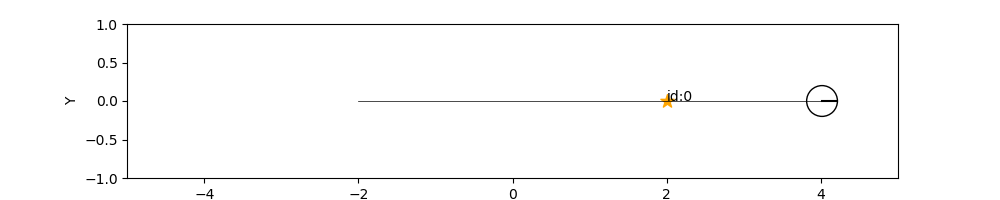

In [9]:
if __name__ == '__main__':   ###name_indent
    world = World(30, 0.1) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(2))
    world.append(m)          

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)    
    circling = Agent(0.2, 10.0/180*math.pi)  
    robot1 = IdealRobot( np.array([ -2, 0]).T,   sensor=IdealCamera(m), agent=straight )             # 引数にcameraを追加、整理
    world.append(robot1)

    ### アニメーション実行 ###
    world.draw()